# Zarządzanie ryzykiem w firmie Nvidia - raport 4

## Dane - ceny miedzi (?)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statistics import stdev
import scipy.stats as sp
from scipy.stats import median_abs_deviation, skew, kurtosis
from scipy.stats import norm, logistic, laplace
from scipy.stats import pearsonr
from scipy.special import erf
import seaborn as sns; sns.set()

In [3]:
def equalize(df, d): #funkcja ta skaluje ceny miedzi do cen za tonę
    col_names = [col for col in df.columns][1:]
    col_names.remove('Volume')
    for name in col_names:
        df[name] = df[name]*d
    return df

def draw_stock(df, clr, title): #funkcja rysuje wykres cen
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1]
    prices = df['Open'].values[::-1]
    plt.plot(dates, prices, color = clr)
    plt.ylabel('USD')
    plt.title(title, fontsize = 25)
    plt.show()
    
def draw_ret(df, clr, title): #funkcja rysuje wykres log stóp zwrotu
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1][:-1]
    prices1 = df['Open'].values[::-1][1:]
    prices2 = df['Open'].values[::-1][:-1]
    r = np.log(prices1/prices2)
    plt.plot(dates, r, color = clr, lw=1)
    plt.title(title, fontsize = 25)
    plt.show()

In [4]:
copper_ = pd.read_csv('../data/copper.csv', sep = ',', encoding = 'latin-1')
copper = equalize(copper_, 2204.623)
copper

,Date,Close/Last,Volume,Open,High,Low
0,04/14/2023,9053.284349,98124,9101.786056,9249.495796,9027.931185
1,04/13/2023,9091.865252,88437,8972.815610,9133.753089,8936.439330
2,04/12/2023,8997.066463,88325,8883.528378,9012.498824,8783.218032
3,04/11/2023,8861.482148,81243,8789.831901,8937.541642,8769.990294
4,04/10/2023,8766.683360,53745,8858.175214,8905.574609,8736.920949
...,...,...,...,...,...,...
1255,04/20/2018,6956.687877,33960,6942.357827,6985.347975,6894.958432
1256,04/19/2018,6953.380942,37634,7018.417320,7094.476814,6911.493105
1257,04/18/2018,7014.008075,51721,6856.377530,7058.100534,6833.228989
1258,04/17/2018,6789.136529,88784,6797.955020,6838.740546,6734.020954


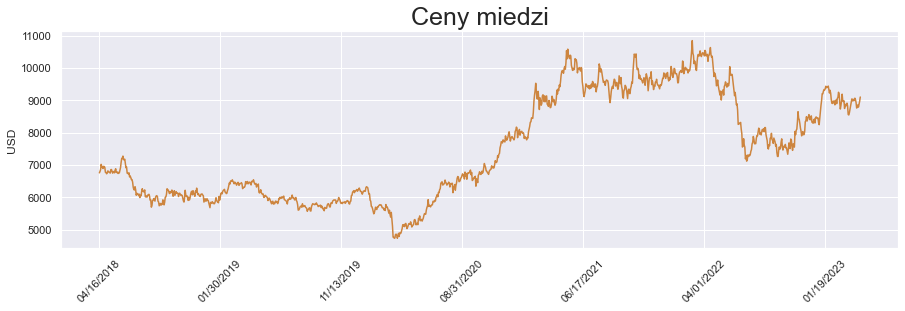

In [5]:
draw_stock(copper, 'peru', 'Ceny miedzi')

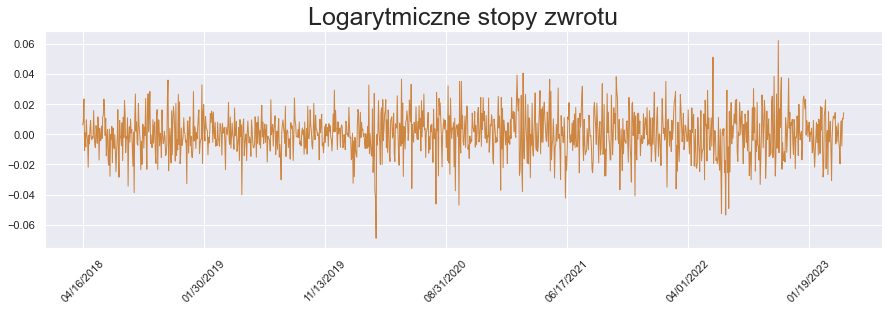

In [6]:
s_copper = np.array(copper['Open'].values)
r_copper = np.log(s_copper[1:]/s_copper[:-1]) #tu są logarytmiczne stopy zwrotu
t_copper = np.array([*range(len(r_copper))])
draw_ret(copper, 'peru', 'Logarytmiczne stopy zwrotu')

## Metoda parametryczna

In [7]:
from scipy.stats import logistic

In [8]:
mi = np.mean(r_copper)
sigma = stdev(r_copper)
p = [.95,.99]
lgstc = logistic.ppf(p, mi, math.sqrt(3)/math.pi*sigma)

In [9]:
lgstc

array([0.02291373, 0.0358921 ])

## Metoda historyczna - zwykła

In [10]:
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd


In [11]:
distr_copper = ECDF(r_copper)

In [43]:
VaR_95 = np.quantile(r_copper,.95)
VaR_99 = np.quantile(r_copper,.99)
print(VaR_95,VaR_99)

0.02347116338449104 0.037608719620069585


In [44]:
new = sorted(r_copper)
new[-20:-1]

[0.034383730890892694,
 0.035060365329832414,
 0.03598191610437585,
 0.036217098442325554,
 0.03679416767819919,
 0.03710514617975447,
 0.037502320728765505,
 0.0377556514223466,
 0.03796982166926521,
 0.03872921384712447,
 0.040177318447642676,
 0.0408684726406883,
 0.04225385627110658,
 0.0423773121323162,
 0.04629157474298002,
 0.047009588531809005,
 0.0492135496536345,
 0.05266769997342544,
 0.0535525235669869]

In [38]:
# Example dataset
data = np.array([10, 20, 30, 40, 50])

# Computing the 25th and 75th percentiles
quantile_25 = np.quantile(data, 0.6)
quantile_75 = np.quantile(data, 0.75)

print(quantile_25)  # 25th percentile
print(quantile_75)  # 75th percentile

34.0
40.0


## Metoda historyczna - ważona

In [16]:
lambda_weight = .99

In [17]:
lambda_s = [lambda_weight**i for i in range(1,len(r_copper))]
ws = np.zeros((len(r_copper)))
ws[0] = 1/(1+sum(lambda_s))
ws[1:] = [ws[0]*lambda_weight**i for i in range(1,len(r_copper))]

In [18]:
ws = np.transpose(ws)
L = np.transpose(r_copper)

In [19]:
aaaa = np.array([r_copper,ws])
aaaa = np.transpose(aaaa)

In [20]:
aaaa

array([[-1.42711454e-02,  1.00000320e-02],
       [-1.00007007e-02,  9.90003165e-03],
       [-1.06032304e-02,  9.80103133e-03],
       ...,
       [-2.33584943e-02,  3.29462358e-08],
       [-8.55741074e-03,  3.26167735e-08],
       [-6.18089151e-03,  3.22906057e-08]])

In [21]:
hist_weight = pd.DataFrame(aaaa,columns=['L','w'])


In [22]:
hist_weight = hist_weight.sort_values(by=['L'])
hist_weight = hist_weight.reset_index(drop=True)


In [45]:
hist_weight['w_s'] = np.zeros(len(r_copper))
hist_weight

,L,w,w_s
0,-0.062109,0.003378,0.0
1,-0.051120,0.001141,0.0
2,-0.040523,0.000049,0.0
3,-0.039250,0.000044,0.0
4,-0.038452,0.003148,0.0
...,...,...,...
1254,0.047010,0.000017,0.0
1255,0.049214,0.001481,0.0
1256,0.052668,0.001313,0.0
1257,0.053553,0.001409,0.0


In [24]:

for i in range(0,len(r_copper)):
    hist_weight['w_s'][i] = sum(hist_weight['w'][:i+1])

In [33]:
hist_weight['w_s']

0       0.003378
1       0.004518
2       0.004567
3       0.004611
4       0.007759
          ...   
1254    0.995792
1255    0.997274
1256    0.998587
1257    0.999996
1258    1.000000
Name: w_s, Length: 1259, dtype: float64

In [25]:
ws_min_95 = min(abs(hist_weight['w_s']-0.95))
ws_min_99 = min(abs(hist_weight['w_s']-0.99))
print(ws_min_99)

0.001052704623480838


In [26]:
hist_weight[hist_weight['w_s'] == ws_min_95+.95]

,L,w,w_s
1204,0.024475,0.002305,0.950033


In [27]:
hist_weight_95 = hist_weight.iloc[(hist_weight['w_s']-.99).abs().argsort()[:1]][['L']]
hist_weight_95

,L
1234,0.030807


In [28]:
hist_weight_99 = float(hist_weight.iloc[(hist_weight['w_s']-.99).abs().argsort()[:1]]['L'])
hist_weight_99 #ja pierdole, oby tak miało być xd

0.030806771642757462

In [29]:
def hist_weight_fun(lam,ps,x):
    n = len(x)
    lambda_s = [lam**i for i in range(1,n)]
    
    ws = np.zeros((n))
    ws[0] = 1/(1+sum(lambda_s))
    ws[1:] = [ws[0]*lambda_weight**i for i in range(1,n)]

    m = np.array([x,ws])
    mt = np.transpose(m)
    hist_weight = pd.DataFrame(mt,columns=['L','w'])
    hist_weight = hist_weight.sort_values(by=['L'])
    hist_weight = hist_weight.reset_index(drop=True)

    hist_weight['w_s'] = np.zeros(n)
    for i in range(0,n):
        hist_weight['w_s'][i] = sum(hist_weight['w'][:i+1])

    result = [float(hist_weight.iloc[(hist_weight['w_s']-p).abs().argsort()[:1]]['L']) for p in ps]
    return(result)


In [30]:
hist_weight_fun(.99,[.95,.99],r_copper)

[0.024475034714765666, 0.030806771642757462]

## Metoda historyczna - GARCH

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.collections import PolyCollection
from arch import arch_model

ModuleNotFoundError: No module named 'arch'

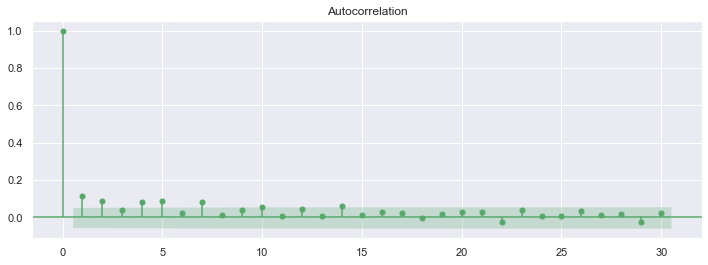

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(r_copper**2, lags = 30, ax = ax, color = 'g', vlines_kwargs = {"colors": 'g'})
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('g')
plt.show()

Iteration:      1,   Func. Count:     33,   Neg. LLF: -1785.467244282064
Iteration:      2,   Func. Count:     68,   Neg. LLF: -2444.842755161767
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2444.842755308566
            Iterations: 6
            Function evaluations: 68
            Gradient evaluations: 2


D:\Anaconda\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002324. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
D:\Anaconda\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


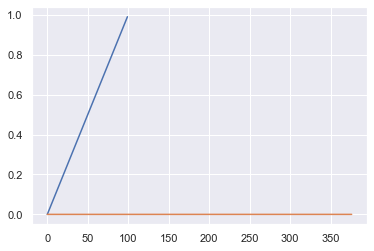

In [ ]:
n_test = math.floor(0.3*len(r_copper))
train, test = r_copper[:-n_test], r_copper[-n_test:]
# define model
model = arch_model(train, mean='Zero', vol='GARCH', p=15, q=15)
# fit model
model_fit = model.fit()
# forecast the test set
yhat = model_fit.forecast(horizon = n_test)
# plot the actual variance
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-n_test:])
# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.show()

377

## Metoda Monte Carlo

## Testowanie wsteczne